## Setup: Install Required Libraries

This block installs the necessary libraries for the project, including:

- `tensorflow-datasets`: For loading pre-built datasets.
- `mlflow`: To track and manage machine learning experiments.
- `gradio`: For creating user interfaces for model predictions.
- `nltk`: For natural language processing tasks.
- `langdetect`: To detect the language of text inputs.
- `gensim`: For topic modeling and other NLP-related tasks.


In [1]:
!pip install -q tensorflow-datasets
!pip install mlflow
!pip install gradio
!pip install nltk
!pip install langdetect
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.6/565.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.

## Download and Load Stopwords

This block uses the `nltk` library to download and load the English stopwords list. Stopwords are common words (e.g., "and", "the") that are usually removed from text data to improve model performance in NLP tasks.


In [2]:
import nltk
nltk.download('stopwords')
# Import stopwords from nltk.corpus
from nltk.corpus import stopwords
# Load NLTK stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Import Libraries for Model Development and Preprocessing

This block imports essential libraries for:

- **Data handling**: `tensorflow_datasets`, `tensorflow`, and `nltk` for NLP tasks and model building.
- **Model creation**: Using `Sequential`, `Embedding`, `LSTM`, `Dense`, and `Dropout` layers from TensorFlow's Keras API.
- **Text preprocessing**: `Tokenizer` and `pad_sequences` from TensorFlow, and regular expressions (`re`) for text cleaning.
- **Data splitting**: `train_test_split` from scikit-learn for creating train/test datasets.
- **ML experiment tracking**: `mlflow` and `mlflow.tensorflow` to track models and experiments.
- **User interface**: `gradio` for building the front-end for the model.
- **Visualization**: `matplotlib.pyplot` for plotting model performance.


In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split  # Import train_test_split
import mlflow
import mlflow.tensorflow
import gradio as gr
import re
import nltk
import matplotlib.pyplot as plt


## Function to Display Dataset Samples

This function, `print_samples`, retrieves and displays a specified number of samples from the dataset. It prints both the text review and its corresponding label (Positive or Negative) to provide a quick overview of the data.


In [4]:
# Function to display some examples from the dataset
def print_samples(dataset, num_samples=5):
    for i, (text, label) in enumerate(dataset.take(num_samples)):
        print(f"Sample {i + 1}:")
        print(f"Review: {text.numpy().decode('utf-8')}")
        print(f"Label: {'Positive' if label == 1 else 'Negative'}")
        print("-" * 50)


## Text Preprocessing Function

The `preprocess_text` function cleans and prepares text data for analysis by performing the following operations:

- **Special Character Removal**: Eliminates non-word characters and reduces multiple spaces to a single space.
- **Digit Removal**: Removes numeric characters from the text.
- **URL and Username Removal**: Strips out any URLs and Twitter-style usernames.
- **Single Character Removal**: Removes any single characters from the text.
- **Final Cleanup**: Further removes any remaining special characters and numbers.
- **Tokenization**: Converts the text to lowercase and splits it into individual words.
- **Stopword Removal**: Filters out common stopwords using the previously loaded list.

The cleaned text is returned as a single string.


In [5]:
def preprocess_text(text):
    # Remove all the special characters from text
    text = re.sub(r'\W', ' ', str(text))

    # Remove extra white space from text
    text = re.sub(r'\s+', ' ', text)

    # remove all the special degits
    text = re.sub(r'\d', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove usernames
    text = re.sub(r'@[^\s]+', '', text)

    # Remove all single characters from text
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text
    words = text.lower().split()

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)


## Dataset Preprocessing Function

The `preprocess_dataset` function processes a given dataset by applying the `preprocess_text` function to each text entry. It performs the following tasks:

- **Text Extraction**: Iterates through the dataset to extract the text and its corresponding label.
- **Preprocessing**: Applies the `preprocess_text` function to clean and tokenize each text entry.
- **Storage**: Collects the cleaned texts and their labels into separate lists.

The function returns two lists: one containing the processed texts and the other containing their corresponding labels.


In [6]:
def preprocess_dataset(dataset):
  # Apply preprocessing to the dataset
    texts = []
    labels = []
    for text, label in dataset:
        texts.append(preprocess_text(text.numpy().decode('utf-8')))
        labels.append(label.numpy())
    return texts, labels

## Plot Training History

The `plot_training_history` function visualizes the training process of a machine learning model by plotting the following metrics over epochs:

- **Accuracy**: Displays both training and validation accuracy to assess the model's performance during training.
- **Loss**: Shows the training and validation loss, providing insights into how well the model is learning and whether it is overfitting.

The function creates a dual subplot layout to present these metrics clearly, helping to evaluate model performance visually.


In [7]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Sentiment Prediction Function

The `predict_sentiment` function processes input text and predicts its sentiment (Positive or Negative) using the trained model. The steps involved are:

- **Text Preprocessing**: The input text is cleaned and prepared using the `preprocess_text` function.
- **Text Sequencing**: The preprocessed text is converted into a sequence of integers using the tokenizer.
- **Padding**: The sequences are padded to ensure consistent input length based on the defined `max_len`.
- **Sentiment Prediction**: The model predicts the sentiment based on the padded sequence, returning "Positive" if the prediction probability exceeds 0.5; otherwise, it returns "Negative."

This function enables real-time sentiment analysis on user-provided text.


In [8]:
# Function to preprocess text and predict sentiment
def predict_sentiment(text):
    # Preprocess the input text
    processed_text = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([processed_text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    # Predict sentiment
    prediction = model.predict(padded_seq)

    if prediction > 0.5:
        return "Positive"
    else:
        return "Negative"


## Load the IMDb Dataset

This block loads the IMDb movie reviews dataset using TensorFlow Datasets (TFDS). The dataset is split into two parts:

- **Training Data**: Contains samples for training the sentiment analysis model.
- **Testing Data**: Contains samples for evaluating the model's performance.


In [9]:
# Load IMDb dataset
imdb_data, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_data, test_data = imdb_data['train'], imdb_data['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.39423Q_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.39423Q_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.39423Q_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Display Samples from the Training Dataset

This block prints a selection of samples from the training dataset to provide a quick glimpse of the data. The `print_samples` function is called to display five text reviews along with their corresponding sentiment labels (Positive or Negative).


In [10]:
# Print samples from the training dataset
print("Training Dataset Samples:")
print_samples(train_data, num_samples=5)

Training Dataset Samples:
Sample 1:
Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Label: Negative
--------------------------------------------------
Sample 2:
Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sett

## Merge and Split Datasets

This block merges the training and testing datasets into a single dataset, followed by the following steps:

- **Calculate Sizes**: Determines the sizes for the training and validation splits, allocating 80% of the merged dataset for training and the remaining 20% for validation.
- **Shuffle the Dataset**: Randomly shuffles the merged dataset to ensure a diverse representation of samples in both splits.
- **Create Datasets**: Divides the merged dataset into the `train_dataset` (80%) and `val_dataset` (20%).
- **Print Sizes**: Outputs the sizes of the training and validation datasets for reference.

This process prepares the data for model training and evaluation.


In [11]:
# Merge the training and test datasets
merged_data = train_data.concatenate(test_data)
# Calculate sizes for the splits
train_size = int(0.8 * len(merged_data))  # 80% for training
val_size = len(merged_data) - train_size   # Remaining 20% for validation

# Shuffle the dataset
merged_data = merged_data.shuffle(buffer_size=10000, seed=42)

# Create training and validation datasets
train_dataset = merged_data.take(train_size)
val_dataset = merged_data.skip(train_size)
# Print dataset sizes
print(f'Training data size: {len(train_dataset)}')
print(f'Validation data size: {len(val_dataset)}')

Training data size: 40000
Validation data size: 10000


## Preprocess Training and Validation Datasets

This block preprocesses the training and validation datasets using the `preprocess_dataset` function. It performs the following tasks:


In [12]:
train_texts, train_labels = preprocess_dataset(train_dataset)
test_texts, test_labels = preprocess_dataset(val_dataset)

In [13]:
# Print dataset sizes
print(f'Training data size: {len(train_texts)}')
print(f'Validation data size: {len(train_labels)}')
print(f'Training data size: {len(test_texts)}')
print(f'Validation data size: {len(test_labels)}')

Training data size: 40000
Validation data size: 40000
Training data size: 10000
Validation data size: 10000


## Tokenization and Padding

This block prepares the text data for input into the model by performing the following steps:

- **Tokenizer Initialization**: A `Tokenizer` is created to handle up to 10,000 unique words, with an out-of-vocabulary (OOV) token represented as `<OOV>`.
- **Fit Tokenizer**: The tokenizer is fitted on the `train_texts` to create a word index based on the training data.
- **Convert Texts to Sequences**: The texts are transformed into sequences of integers where each integer corresponds to a specific word in the tokenizer's word index.
- **Padding**: The sequences are padded to a maximum length of 120 tokens, ensuring consistent input size for the model. This includes truncating longer sequences and adding padding to shorter ones.

The shapes of the padded training and test datasets are printed for verification, confirming their dimensions for model input.


In [14]:
# Tokenizer and padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Padding sequences
max_len = 120  # You can adjust this based on your dataset
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

print("Training data shape:", train_padded.shape)
print("Test data shape:", test_padded.shape)


Training data shape: (40000, 120)
Test data shape: (10000, 120)


## Model Architecture Definition

This block defines the architecture of the sentiment analysis model using Keras' Sequential API. The model consists of the following layers:

- **Embedding Layer**: Transforms the input integer sequences into dense vector representations, with an input dimension of 10,000 words and an output dimension of 64.
- **LSTM Layer**: A Long Short-Term Memory (LSTM) layer with 64 units to capture temporal dependencies in the sequences.
- **Dropout Layers**: Two dropout layers with a dropout rate of 0.2 to reduce overfitting by randomly setting a fraction of input units to 0 during training.
- **Dense Layers**: A fully connected dense layer with 64 units and ReLU activation, followed by an output dense layer with a single unit and a sigmoid activation function for binary classification.

The model is compiled using binary cross-entropy loss, the Adam optimizer, and accuracy as the evaluation metric. The model's input shape is manually defined, and a summary of the model architecture is displayed to provide an overview of its structure.


In [15]:
# Define the model architecture
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=120),  # Embedding layer
    LSTM(64, return_sequences=False),  # LSTM layer
    Dropout(0.2),  # Dropout for regularization
    Dense(64, activation='relu'),  # Dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Manually build the model based on input shape
model.build(input_shape=(None, max_len))

# Display the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 120, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 677,249 (2.58 MB)

 Trainable params: 677,249 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

This block trains the defined sentiment analysis model using the padded training data. The `fit` method is called with the following parameters:

- **Training Data**: The model is trained on `train_padded` input data and corresponding `train_labels`, which are converted to a TensorFlow tensor for compatibility.
- **Epochs**: The training process runs for 50 epochs, allowing the model to learn from the data over multiple iterations.
- **Validation Data**: The model's performance is evaluated on the validation set (`test_padded` and `test_labels`) during training to monitor its accuracy and loss.

The training history, which includes metrics such as accuracy and loss over the epochs, is stored in the `history` variable for later analysis.


In [16]:
# Train the model
history = model.fit(
    train_padded,
    tf.convert_to_tensor(train_labels),
    epochs=50,
    validation_data=(test_padded, tf.convert_to_tensor(test_labels))
)


Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.5364 - loss: 0.6836 - val_accuracy: 0.7558 - val_loss: 0.5133
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6970 - loss: 0.5778 - val_accuracy: 0.4973 - val_loss: 0.6933
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.5181 - loss: 0.6918 - val_accuracy: 0.5311 - val_loss: 0.6917
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.5373 - loss: 0.6840 - val_accuracy: 0.7622 - val_loss: 0.5201
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8161 - loss: 0.4420 - val_accuracy: 0.8801 - val_loss: 0.2961
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9013 - loss: 0.2651 - val_accuracy: 0.8931 - val_loss: 0.2682
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9264 - loss: 0.2077 - val_accuracy: 0.9045 - val_loss: 0.2474
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9471 - loss:

## Plot Training History

This block visualizes the training process by plotting the model's accuracy and loss over the epochs. The `plot_training_history` function generates two subplots:

- **Accuracy Plot**: Displays both training accuracy and validation accuracy over the epochs, allowing for an assessment of the model's performance on the training and validation datasets.
- **Loss Plot**: Shows the training loss and validation loss across the epochs, providing insight into how well the model is learning and whether it is overfitting.

These visualizations help in understanding the model's training dynamics and its ability to generalize to unseen data.


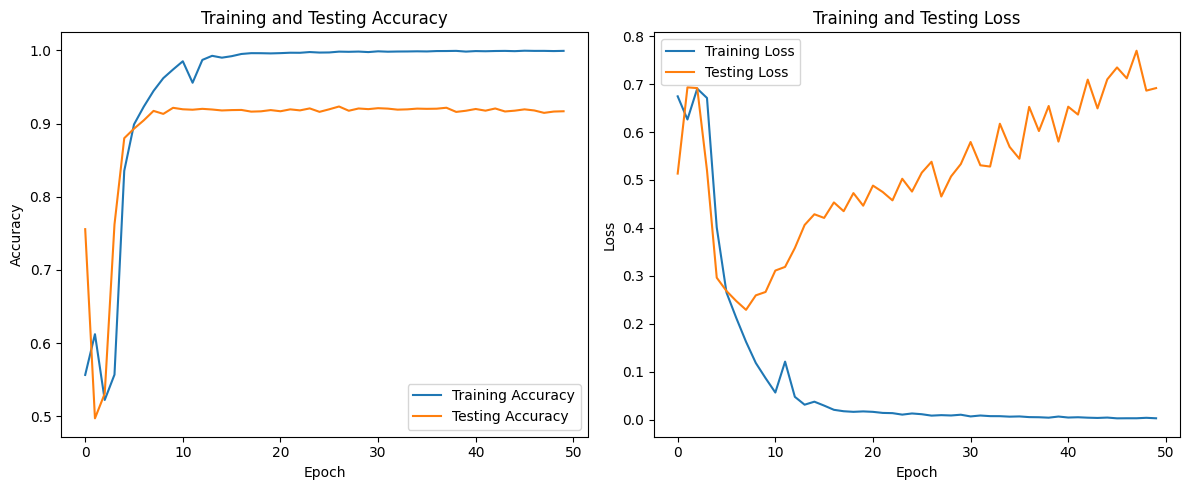

In [17]:
plot_training_history(history)


## Model Evaluation

This block evaluates the performance of the trained sentiment analysis model on the validation dataset.


In [18]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_padded, tf.convert_to_tensor(test_labels))
print(f"Test Accuracy: {test_acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9190 - loss: 0.6688
Test Accuracy: 0.9169


## Logging the Model with MLflow

This block integrates the trained model with MLflow for tracking and managing the machine learning lifecycle. The process includes:

- **Start MLflow Run**: Initiates a new run to track the model's parameters, metrics, and artifacts.
- **Log Model**: The trained sentiment analysis model is saved to MLflow using `mlflow.tensorflow.log_model`, with the model artifacts stored under the specified path "model". This allows for easy versioning and retrieval of the model later.
- **End MLflow Run**: Concludes the logging session, finalizing the entry for this run in the MLflow tracking server.

Using MLflow helps in maintaining a record of model training sessions and facilitates experimentation with different model versions.


In [19]:
# Start an MLflow run
mlflow.start_run()

# Save the model to MLflow (without specifying 'tf_model')
mlflow.tensorflow.log_model(model, artifact_path="model")

# End the MLflow run
mlflow.end_run()

2024/10/16 19:04:06 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/10/16 19:04:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Creating and Launching the Gradio Interface

This block sets up a user-friendly interface for the sentiment analysis model using Gradio. The interface is defined with the following parameters:

- **Function**: The `predict_sentiment` function is specified as the function to be called when a user inputs text.
- **Inputs**: The interface accepts a single text input, allowing users to enter movie reviews for sentiment classification.
- **Outputs**: The model's prediction (either "Positive" or "Negative") is returned as text output.
- **Title and Description**: A title ("Sentiment Classifier") and a brief description are provided to guide users on how to interact with the interface.

Finally, the Gradio interface is launched, making it accessible for users to input their reviews and receive sentiment predictions in real-time.


In [20]:
# Create the Gradio interface
gr_interface = gr.Interface(
    fn=predict_sentiment,
    inputs="text",
    outputs="text",
    title="Sentiment Classifier",
    description="Enter a movie review, and the model will predict if it's Positive or Negative."
)
# Launch the Gradio interface
gr_interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://621b15cf084efa3537.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
